In [1]:
from IPython.display import display, HTML #make wider
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import COASTLINE
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from scipy.stats import binned_statistic_2d

from mpl_toolkits.basemap import Basemap
from cartopy.feature import LAND, OCEAN, COASTLINE  # Import the LAND, OCEAN and COASTLINE features
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter 
from matplotlib.ticker import MaxNLocator  # Import MaxNLocator
from matplotlib.path import Path
import os

def set_color_definitions(cri):
    global colors, intensity_labels, boundary_norm
    if cri == 0 or cri == 1:
        colors = ["cornflowerblue", "forestgreen", "orange", "magenta", "red"]
        intensity_labels = ["TS", "STS", "TY", "STY", "SSTY"]
        boundary_norm = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
        ncol = 5
        
    elif cri == 2:
        colors = ["cornflowerblue", "forestgreen", "orange", "magenta", "red", "purple"]
        intensity_labels = ["TS", "CAT1", "CAT2", "CAT3", "CAT4", "CAT5"]
        boundary_norm = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
        ncol = 6


def plot_storm_tracks(storm_data, ax, mstep, cri):

    # Call set_color_definitions to set the color definitions
    set_color_definitions(cri)

    # Create a list to store storm data temporarily
    storm_data_temp = []

    for storm_id, storm_d in storm_data.groupby('SID'):
        if len(storm_d) >= mstep:
            max_uni_cat = storm_d['UNI_CAT'].max()
            storm_data_temp.append((storm_d, max_uni_cat))

    # Sort the storm data by the maximum 'UNI_CAT' value in ascending order
    storm_data_temp.sort(key=lambda x: x[1])

    scount = 0
    min_len = 4  # just for drawing
    
    for storm_d, max_uni_cat in storm_data_temp:
        check = 0
        scount += 1
        x = np.array(storm_d['LON'])
        y = np.array(storm_d['LAT'])
        CAT = np.array(storm_d['UNI_CAT'])
        tmp_x, tmp_y, tmp_CAT = [], [], []

        for i in range(len(x)-1):
            if abs(x[i+1]-x[i]) < 120:
                tmp_x.append(x[i])
                tmp_y.append(y[i])
                tmp_CAT.append(CAT[i])

            else:              
                if len(tmp_x)>min_len: # min_len = 10 was used in early days
                    xx = savitzky_golay(tmp_x, 11, 3)
                    yy = savitzky_golay(tmp_y, 11, 3)
                    dydx = tmp_CAT

                    points = np.array([xx, yy]).T.reshape(-1, 1, 2)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)

                    cmap = ListedColormap(colors)
                    norm = BoundaryNorm(boundary_norm, cmap.N)

                    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1)
                    lc.set_array(dydx)

                    ax.add_collection(lc)

                del tmp_x, tmp_y, tmp_CAT
                tmp_x = []
                tmp_y = []
                tmp_CAT = []
        if len(tmp_x)>min_len:
            xx = savitzky_golay(tmp_x, 11, 5)
            yy = savitzky_golay(tmp_y, 11, 5)
            dydx = tmp_CAT

            points = np.array([xx, yy]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            cmap = ListedColormap(colors)
            norm = BoundaryNorm(boundary_norm, cmap.N)

            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1)
            lc.set_array(dydx)

            ax.add_collection(lc)

    return scount

def setup_map_and_grid(ax, lon1, lon2, lat1, lat2):
    ax.add_feature(COASTLINE, edgecolor='black', zorder=10)
    ax.add_feature(LAND, facecolor="burlywood", alpha=0.9)     # Set the land color to a semi-transparent shade of brown
    ax.add_feature(OCEAN, facecolor="lightblue", alpha=0.9)
    ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.7, color='gray', alpha=0.5, linestyle='--', dms=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.bottom_labels = False

def create_custom_legend():
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=15, label=intensity_labels[i])
                       for i in range(len(colors))]
    return legend_elements

#########   self defined version of savitzky golay filter   ####################################
def savitzky_golay(y, window_size, order, deriv=0, rate=1):

    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

###############################################################################################

# Function to calculate frequency distribution
def calculate_frequency_distribution(sub_data, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep):
    # Filter out short-lived storms
    sub_data = sub_data.groupby('SID').filter(lambda x: len(x) >= mstep)

    # Calculate the total number of years in the dataset
    total_years = sub_data['YEAR'].nunique()

    # Calculate the frequency map
    lon = sub_data['LON']
    lat = sub_data['LAT']
    bins_x = np.arange(lon_min, lon_max, grid_resolution)
    bins_y = np.arange(lat_min, lat_max, grid_resolution)
    frequency, _, _ = np.histogram2d(lon, lat, bins=[bins_x, bins_y])

    # Calculate the average frequency per year for each grid cell
    average_frequency = frequency / total_years

    # Replace NaN values with 0 to display them as white in plots
    average_frequency[np.isnan(average_frequency)] = 0

    return average_frequency

def calculate_genesis_frequency(storm_data, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep):
    
    # Calculate the total number of years in the dataset
    total_years = storm_data['YEAR'].nunique()    
    
    # Create a DataFrame to store storm data temporarily
    storm_data_temp = pd.DataFrame(columns=['LON', 'LAT'])

    scount = 0

    for storm_id, storm_d in storm_data.groupby('SID'):
        # Filter out short-lived storms
        if len(storm_d) >= mstep:
            # Take only the first point of each storm track
            genesis_point = storm_d.iloc[0]
            # Append the 'LON' and 'LAT' values to the temporary DataFrame
            storm_data_temp.loc[scount, 'LON'] = genesis_point['LON']
            storm_data_temp.loc[scount, 'LAT'] = genesis_point['LAT']
            scount += 1

    # Convert 'LON' and 'LAT' columns to numeric
    storm_data_temp['LON'] = pd.to_numeric(storm_data_temp['LON'])
    storm_data_temp['LAT'] = pd.to_numeric(storm_data_temp['LAT'])

    # Calculate the frequency map
    lon = storm_data_temp['LON']
    lat = storm_data_temp['LAT']
    bins_x = np.arange(lon_min, lon_max, grid_resolution)
    bins_y = np.arange(lat_min, lat_max, grid_resolution)
    frequency, _, _ = np.histogram2d(lon, lat, bins=[bins_x, bins_y])

    # Calculate the average frequency per year for each grid cell
    average_genesis_frequency = frequency / total_years

    # Replace NaN values with 0 to display them as white in plots
    average_genesis_frequency[np.isnan(average_genesis_frequency)] = 0

    return average_genesis_frequency



In [3]:
#####################################################################################################
# convert to (-180, 180) | year-range selection | domain selection ##################################
def trans_trim_dframe(df, lon_col='LON', lat_col='LAT', time_col='ISO_TIME', start_year=None, end_year=None, lon_min=None, lon_max=None, lat_min=None, lat_max=None):
    # Transform 'LON' values to (-180, 180) range
    df[lon_col] = df[lon_col].apply(lambda lon: lon if lon <= 180 else lon - 360)

    # Extract the years from the "ISO_TIME" column
    df['YEAR'] = pd.to_datetime(df[time_col]).dt.year

    # Filter data for the needed years
    if start_year is not None and end_year is not None:
        y_range = range(start_year, end_year + 1)
        df = df[df['YEAR'].isin(y_range)]

    # Filter data for the specified region
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        df = df[(df[lon_col] >= lon_min) & (df[lon_col] <= lon_max) &
                (df[lat_col] >= lat_min) & (df[lat_col] <= lat_max)]

    return df

###############################################################################################

def point_in_polygon(lon, lat, polygon_path):
    return polygon_path.contains_point((lon, lat))

def basin_data(in_df, basin=None):
    
    # Read the dataframe
    df = in_df
    
    # Convert longitude values from [0, 360) to [-180, 180)
    df['LON'] = (df['LON'] + 180) % 360 - 180

    # Check if basin is provided
    if basin is not None:
        # Define the polygon coordinates based on the provided basin
        
        if basin == 'Glb':
            polygon_coords = np.array([[-180, 50], [-180, -50], [180, -50], [180, 50], [-180, 50]])
            
        elif basin == 'NA':
            polygon_coords = np.array([[-70, 0], [-100, 20], [-100, 50], [0, 50], [0, 0], [-70, 0]])
            
        elif basin == 'EP':
            polygon_coords = np.array([[-70, 0], [-100, 20], [-100, 50], [-180, 50], [-180, 0], [-70, 0]])            
            
        elif basin == 'WNP': 
            polygon_coords = np.array([[100, 0], [100, 50], [180, 50], [180, 0], [100, 0]]) 
            
        elif basin == 'NI': 
            polygon_coords = np.array([[30, 0], [30, 50], [100, 50], [100, 0], [30, 0]]) 

        elif basin == 'SI': 
            polygon_coords = np.array([[10, 0], [10, -50], [135, -50], [135, 0], [10, 0]])            

        elif basin == 'SA': 
            polygon_coords = np.array([[10, 0], [10, -50], [-70, -50], [-70, 0], [10, 0]]) 

        elif basin == 'SP':  # this is special case. So, coordinate in 0 to 360 form
            polygon_coords = np.array([[135, 0], [135, -50], [290, -50], [290, 0], [135, 0]]) 

        # Create the polygon path
        polygon_path = Path(polygon_coords)

        # Filter rows based on the condition      
        if basin == 'SP':
            
            # Convert longitude values from [-180, 180] to [0, 360] before applying mask
            df['LON'] = (df['LON'] + 360) % 360 
            
            mask = df.apply(lambda row: point_in_polygon(row['LON'], row['LAT'], polygon_path), axis=1)
            filtered_df = df[mask]
    
            # Convert longitude values from back to [-180, 180]
            filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
            
        else:
            mask = df.apply(lambda row: point_in_polygon(row['LON'], row['LAT'], polygon_path), axis=1)
            filtered_df = df[mask]
            
        return filtered_df
    # If basin is not provided, return the original DataFrame
    return df


/tmp/ipykernel_1892/540132107.py:4: DtypeWarning: Columns (21,66,128,143) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_data_1 = pd.read_csv('../Data/IBTrACS_[Bourdin2022].csv')


Figure saved as: ../Figure/05_Global Distribution of TC Track and Genesis Frequencies.pdf


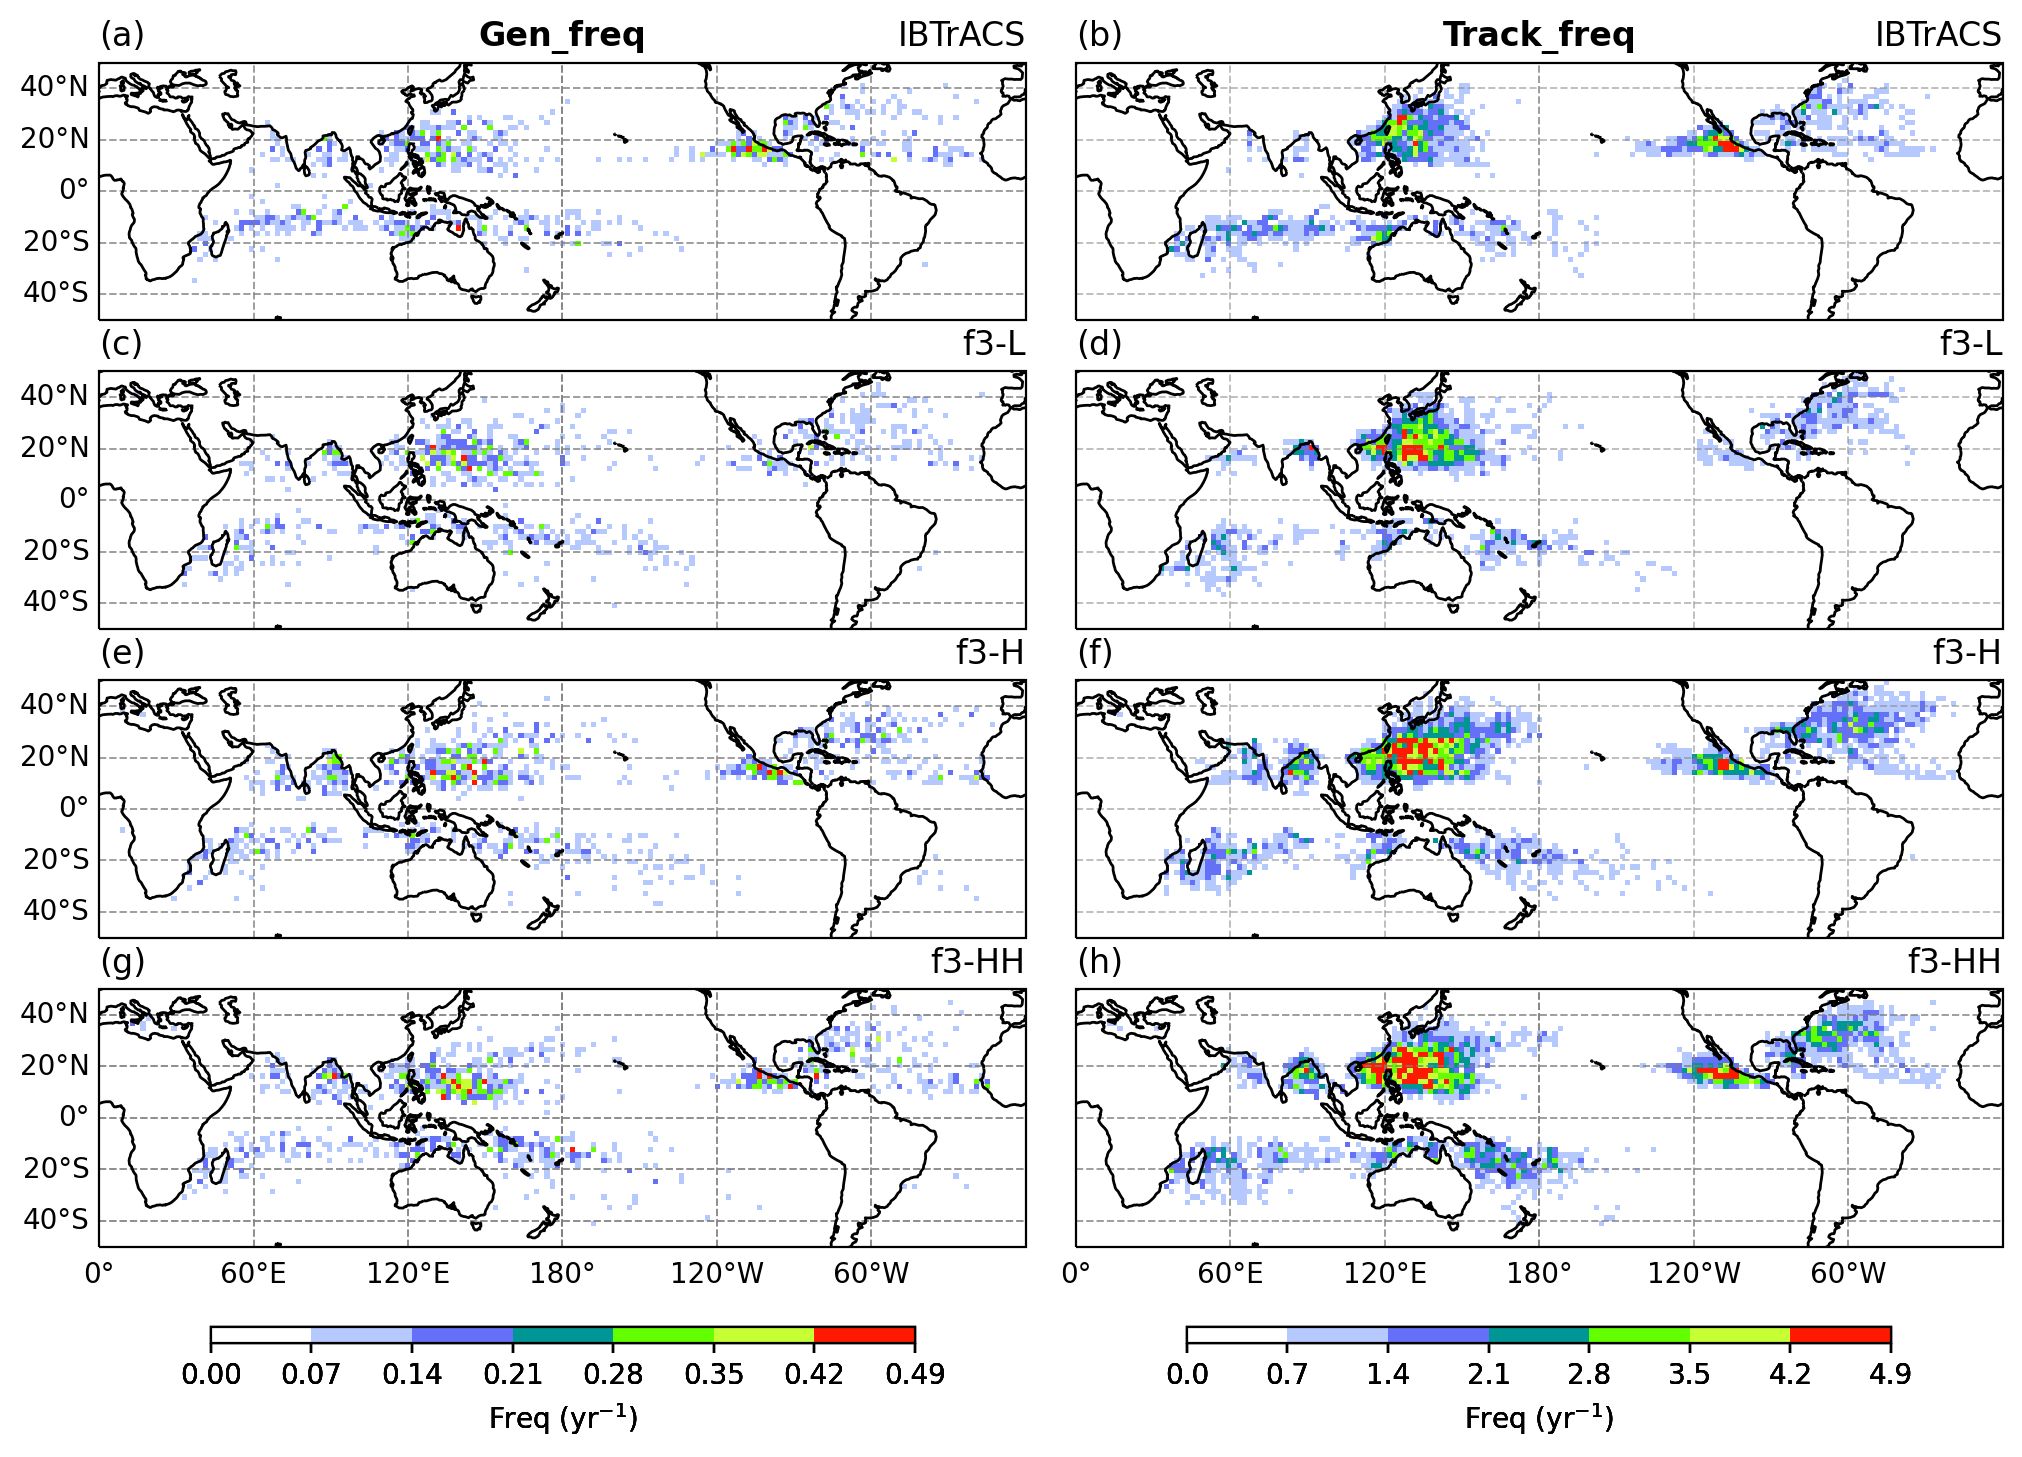

In [4]:
# Level - 2 (well adjusted for 2*2 grid)

# Load your datasets
sub_data_1 = pd.read_csv('../Data/IBTrACS_[Bourdin2022].csv')
sub_data_2 = pd.read_csv('../Data/f3L_w15.2_Walsh.csv')
sub_data_3 = pd.read_csv('../Data/f3H_w17.1_Walsh.csv')
sub_data_4 = pd.read_csv('../Data/f3HH_w17.4_Walsh.csv')

exp_name_1 = 'IBTrACS'
exp_name_2 = 'f3-L'
exp_name_3 = 'f3-H'
exp_name_4 = 'f3-HH'

start_year = 1998
end_year = 2007

# Define the domain (this is for global TC region)
lon_min, lon_max = -180, 180
lat_min, lat_max = -50, 50

# Define the step threshold for dropping out short-lived systems
mstep_ob = 4
mstep_mo = 12
cri = 2   # 0-Liu, 1-CMA, 2-SS
cls ='SS'

# Define the grid resolution for track density
grid_resolution = 2      # 1,2,5 degree typically
common_max_fvalue = 5.6   # 2.4, 5.6, 24   This is for color scale, this value based on your data

# To filter data for the needed years
y_range = range(start_year, end_year+1)


# Ready to go ....

sub_data_1 = trans_trim_dframe(sub_data_1, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)
sub_data_2 = trans_trim_dframe(sub_data_2, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)
sub_data_3 = trans_trim_dframe(sub_data_3, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)
sub_data_4 = trans_trim_dframe(sub_data_4, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)

################################################################################################
# Define the custom colors segments for Freq.
colorsF = ['#FFFFFF', '#D7E2FE', '#B5C9FE',  '#7F96FE', '#6470F8', 
          '#0063FF', '#009695', '#00C633', '#63FE00', '#96FF00', '#C6FF34',
          '#FFFF00', '#FFC501', '#FF9F00', '#FF7C00', '#FF1901']   # 4th color was taken out to keep the balance here '#8EB2FF',


# common_max_fvalue = 1    # Define a common maximum frequency value for all subplots
num_colors = 8           # Define the number of desired colors
color_scale = common_max_fvalue / num_colors   #Calculate the color scale based on the common maximum frequency value and the number of colors
adjusted_colorsF = [colorsF[int(i)] for i in np.linspace(0, len(colorsF) - 1, num_colors).astype(int)]   # Create a list of colors for the custom colormap, evenly distributed from colorsF

# Create a custom colormap and normalize based on intensity
cmapF = ListedColormap(adjusted_colorsF)
normF = BoundaryNorm(np.arange(0, common_max_fvalue, color_scale), cmapF.N)

################################################################################################


# Create a 4x2 subplot grid
fig, axs = plt.subplots(4, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}) # this is only for background map
fig.set_dpi(200)

lon1, lon2, lat1, lat2 = -180, 180, -50, 50  # Mapping area


# To GET PACIFIC OCEAN AT CENTER OF THE PLOT
for i, sub_data in enumerate([sub_data_1, sub_data_2, sub_data_3, sub_data_4]):

    # Transform 'LON' from (-180, 180) to (-180, 180) but artificial axis
    sub_data['LON'] = sub_data['LON'].apply(lambda lon: lon-180 if lon >= 0 else lon+180)  # this is for data in the dataframe, CAUTION: DATA MUST BE in (-180 to 180) only before applying this method (-180 to 360 is not valid)

##################################################################################################################################################################################
    
# Calculate Genesis frequency and plot them
for i, (ax, sub_data, exp_name) in enumerate(zip(axs[:,0], [sub_data_1, sub_data_2, sub_data_3, sub_data_4], [exp_name_1, exp_name_2, exp_name_3, exp_name_4])):

    if exp_name == exp_name_1:    
        mstep = mstep_ob
    else:
        mstep = mstep_mo    
    
    genesis_frequency = calculate_genesis_frequency(sub_data, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep)
    
    # Create a new BoundaryNorm with scaled down boundaries
    norm_genesis = BoundaryNorm(np.arange(0, common_max_fvalue / 10, color_scale / 10 ), cmapF.N) # [common_max_fvalue / 10] ; because genesis is almost 10 times weaker 

    # Plot the Genesis frequency distribution with the new normalization
    im = ax.imshow(genesis_frequency.T, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cmapF, norm=norm_genesis, origin='lower')

    # Create a separate axes for the colorbar
    cax = fig.add_axes([0.25, 0.05, 0.22, 0.01])  #[x, y, width, height] Adjust the position and size as needed

    # Add the colorbar to the separate axes with the original normalization
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label('Freq (yr$^{-1}$)')

    setup_map_and_grid(ax, lon1, lon2, lat1, lat2)
    ax.set_title(f'{exp_name}', loc='right') # loc='left' , weight='bold'


# Calculate frequency distributions and plot them
for i, (ax, sub_data, exp_name) in enumerate(zip(axs[:,1], [sub_data_1, sub_data_2, sub_data_3, sub_data_4], [exp_name_1, exp_name_2, exp_name_3, exp_name_4])):

    if exp_name == exp_name_1:    
        mstep = mstep_ob
    else:
        mstep = mstep_mo
        
    frequency_distribution = calculate_frequency_distribution(sub_data, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep)
    # Plot the frequency distribution
    im = ax.imshow(frequency_distribution.T, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cmapF, norm=normF, origin='lower')

    # Create a separate axes for the colorbar to the left of the subplot
    cax = fig.add_axes([0.555, 0.05, 0.22, 0.01])  #[x, y, width, height] Adjust the position and size as needed

    # Add the colorbar to the separate axes
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label('Freq (yr$^{-1}$)')

    setup_map_and_grid(ax, lon1, lon2, lat1, lat2)
    ax.set_title(f'{exp_name}', loc='right') # weight='bold'
    

#############################################################################################################################    
ax_px=0.0
ax_py=1.065 # 0.99

# Add labeling for the first row
for i, label in enumerate(['a', 'b']):
    axs[0][i].text(ax_px, ax_py, f'({label})', transform=axs[0][i].transAxes, fontsize=12) # weight='bold'
    
# Add labeling for the second row
for i, label in enumerate(['c', 'd']):
    axs[1][i].text(ax_px, ax_py, f'({label})', transform=axs[1][i].transAxes, fontsize=12) # weight='bold'

# Add labeling
for i, label in enumerate(['e', 'f']):
    axs[2][i].text(ax_px, ax_py, f'({label})', transform=axs[2][i].transAxes, fontsize=12) # weight='bold'

# Add labeling
for i, label in enumerate(['g', 'h']):
    axs[3][i].text(ax_px, ax_py, f'({label})', transform=axs[3][i].transAxes, fontsize=12) # weight='bold'
    gl = axs[3][i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.7, color='gray', alpha=0.5, linestyle='--', dms=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    
# Customize subplots labels column-wise
for i, label in enumerate(['a', 'c', 'e', 'g']):
    gl = axs[i][0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.7, color='gray', alpha=0.5, linestyle='--', dms=True)
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False

axs[0][0].set_title(f'Gen_freq', loc='center', fontsize=12, weight='bold')   
axs[0][1].set_title(f'Track_freq', loc='center', fontsize=12, weight='bold')   

# Set a meaningful title for the entire figure
# fig.suptitle(f'Tropical Cyclone Distribution over the Globe ({start_year}-{end_year}) Cri: SS', fontsize=16, y=0.93)
# Adjust the gap between subplots and figure title

fig.subplots_adjust(top=0.85, hspace=0.2, wspace=-0.35)
# plt.tight_layout()

# Save the figure
os.makedirs('../Figure', exist_ok=True)
save_path = '../Figure/05_Global Distribution of TC Track and Genesis Frequencies.pdf'
plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
print(f"Figure saved as: {save_path}")    

plt.show()


In [5]:
from scipy.stats import pearsonr

################################################################################################

gfreq_ibtracs = calculate_genesis_frequency(sub_data_1, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep_ob)
tfreq_ibtracs = calculate_frequency_distribution(sub_data_1, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep_ob)

gfreqs = []  # genesis frequencies
gfanoms = [] # genesis freq. anomalies

tfreqs = []  # track frequencies
tfanoms = [] # track freq. anomalies

###################              genesis           ############################################
# Calculate anomalies
for sub_data, exp_name in zip([sub_data_1, sub_data_2, sub_data_3, sub_data_4], 
                              [exp_name_1, exp_name_2, exp_name_3, exp_name_4]):
    mstep = mstep_ob if exp_name == exp_name_1 else mstep_mo

    gfreq_sub = calculate_genesis_frequency(sub_data, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep)
    gfreqs.append(gfreq_sub)
    
    gfanom = gfreq_sub - gfreq_ibtracs
    gfanoms.append(gfanom)

    
# Calculate correlation coefficients
g_pccs = []
g_pcc_pvals = []  # List to store p-values for Pearson's correlation

for gfreq in gfreqs:   
    # Pearson's correlation coefficient and p-value
    g_pcc, g_pcc_pval = pearsonr(gfreq.flatten(), gfreq_ibtracs.flatten())   
    g_pccs.append(g_pcc)
    g_pcc_pvals.append(g_pcc_pval)  # Store p-value for Pearson's correlation
    # g_pcc = np.corrcoef(gfreq.flatten(), gfreq_ibtracs.flatten())[0, 1] #     # pearsons' correlation coefficient using 'np'

        
# Output correlation coefficients
print("genesis frequencies") 
for exp_name, g_pcc, g_pcc_pval in zip([exp_name_1, exp_name_2, exp_name_3, exp_name_4], g_pccs, g_pcc_pvals):
    print(f"PCC for {exp_name}: {g_pcc:.3}, p-val : {g_pcc_pval:.2e}")
         
###################              track            ############################################
# Calculate anomalies
for sub_data, exp_name in zip([sub_data_1, sub_data_2, sub_data_3, sub_data_4], 
                              [exp_name_1, exp_name_2, exp_name_3, exp_name_4]):
    mstep = mstep_ob if exp_name == exp_name_1 else mstep_mo
    tfreq_sub = calculate_frequency_distribution(sub_data, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep)
    tfreqs.append(tfreq_sub)
    
    tfanom = tfreq_sub - tfreq_ibtracs
    tfanoms.append(tfanom)
    
# Calculate correlation coefficients
t_pccs = []
t_pcc_pvals = []  # List to store p-values for Pearson's correlation

for tfreq in tfreqs:
    # Pearson's correlation coefficient and p-value
    t_pcc, t_pcc_pval = pearsonr(tfreq.flatten(), tfreq_ibtracs.flatten())   
    t_pccs.append(t_pcc)
    t_pcc_pvals.append(t_pcc_pval)  # Store p-value for Pearson's correlation
    # t_pcc = np.corrcoef(tfreq.flatten(), tfreq_ibtracs.flatten())[0, 1]       # pearsons' correlation coefficient using 'np'
    
print("")
# Output correlation coefficients
print("track frequencies") 
for exp_name, t_pcc, t_pcc_pval in zip([exp_name_1, exp_name_2, exp_name_3, exp_name_4], t_pccs, t_pcc_pvals):
    print(f"PCC for {exp_name}: {t_pcc:.3}, p-val : {t_pcc_pval:.2e}")


genesis frequencies
PCC for IBTrACS: 1.0, p-val : 0.00e+00
PCC for f3-L: 0.3, p-val : 1.08e-181
PCC for f3-H: 0.369, p-val : 1.18e-280
PCC for f3-HH: 0.393, p-val : 2.67e-322

track frequencies
PCC for IBTrACS: 1.0, p-val : 0.00e+00
PCC for f3-L: 0.663, p-val : 0.00e+00
PCC for f3-H: 0.727, p-val : 0.00e+00
PCC for f3-HH: 0.757, p-val : 0.00e+00


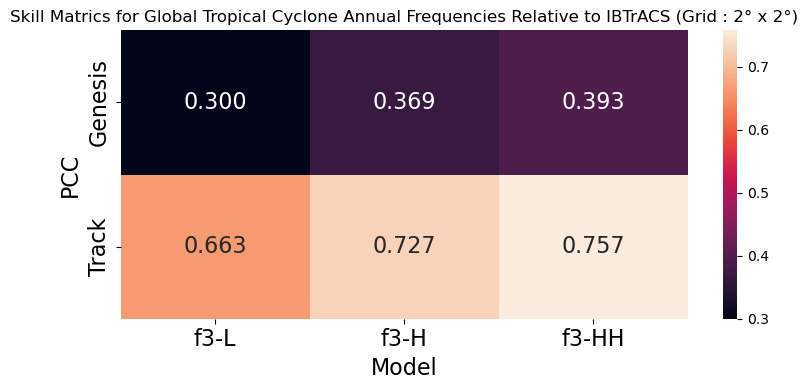

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


correlation_data = np.array([
    g_pccs[1:], 
    t_pccs[1:]
])

# Create a heatmap
plt.figure(figsize=(8, 4))
heatmap = sns.heatmap(correlation_data[:,:], annot=True, fmt=".3f", # cmap='coolwarm', vmin=0.3, vmax=1, 
                      xticklabels=['f3-L', 'f3-H', 'f3-HH'],
                      yticklabels=['Genesis', 'Track'], 
                      annot_kws={"size": 16})

# Increase font size for annotations and labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16)
heatmap.set_xlabel(heatmap.get_xlabel(), fontsize=16)
heatmap.set_ylabel(heatmap.get_ylabel(), fontsize=16)

plt.title(f'Skill Matrics for Global Tropical Cyclone Annual Frequencies Relative to IBTrACS (Grid : {grid_resolution}° x {grid_resolution}°)')
plt.xlabel('Model', fontsize=16)
plt.ylabel('PCC', fontsize=16)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()
